In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import sys

sys.path.append(os.getcwd()[:-10])
from utils.performance_metrics import *
from serial_momentum_functions import *

### In this notebook we will build a serial momentum strategy

There are several ways to determine if momentum exists in a time series (e.g Hurst, (P)ACF), but the simplest and most intuitive idea is when past returns of a price series are positively correlated with future returns.

The first step is to find optimal pair of past and future periods that gives the highest positive correlation and use that as our look-back and holding period for our momentum strategy. Once the optimal pair has been found, a simple strategy can be built -- take a long (short) position when past returns are positive (negative), and hold onto that position for the future period.

We will split our data into a training set (2010/01/01 - 2017/01/01) and a test set (2017/01/01 - 2020/01/01). Parameters are optimised on the training set and test set will be used to evaluate overall performance.

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

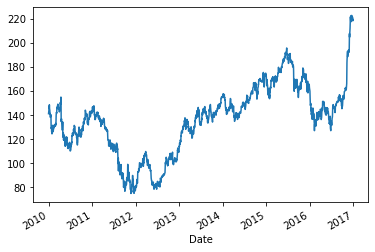

In [2]:
price_data = yf.download('GS',
                         start='2010-01-01',
                         end='2017-01-01')['Adj Close']

price_data.plot()

### Optimising past and future pairs through a gridsearch.

Objectives are the Pearson correlation coefficient, and p-value (probability of an uncorrelated data set producing the correlation results).

Based on the results, lookback=30, forward=25 appears to be optimal

In [3]:
results =\
    gridsearch_lookback_forward_periods(prices = price_data.values,
                                        parameters = {'lookback': np.arange(5, 60) * 5,
                                                      'forward': np.arange(1, 10) * 5})


In [4]:
results.sort_values(by='correlation_coefficient', ascending=False).head()

,lookback,forward,correlation_coefficient,p_value
13,30,25,0.231335,0.055807
3,25,20,0.193342,0.074486
12,30,20,0.163342,0.132912
1,25,10,0.149629,0.049429
21,35,20,0.132540,0.223788


In [5]:
results.sort_values(by='p_value').head()

,lookback,forward,correlation_coefficient,p_value
1,25,10,0.149629,0.049429
13,30,25,0.231335,0.055807
3,25,20,0.193342,0.074486
19,35,10,0.127768,0.094861
12,30,20,0.163342,0.132912


### Implementing Hurst exponents as stop losses

With the optimal pair, we can go ahead and build the simple momentum strategy as stated above. However, the simple strategy only specifies a holding period, and we exit a position when we reached that holding period. As Ernest Chan suggested, we should impose stop losses as an addiotnal exit condition to improve momentum strategies.

One idea is to use Hurst exponents to determine the current regime behaviour. The hurst exponent calculated on the __log prices__ of a time series, H, helps us identify whether the series is mean reverting, random walking or trending. H takes values in [0, 1] and we have the result:

\begin{align*}
&H \ll 0.5 & \text{mean-reverting} \\
&H \approx 0.5 & \text{random walk} \\
&H \gg 0.5 & \text{trending}
\end{align*}

This provides an additional rule for when we should enter or exit trades. By applying hurst calculations on a rolling window, we should enter trades only when we believe the regime is trending, and exit trades either when we have reached the holding period, or when the regime switches to a mean-reverting one. The rolling window size is naturally the lookback period.

References:
- Michael L. Halls Moore. Successful Algorithmic Trading. 
- Ernest P. Chan. Algorithmic Trading.  John Wiley & Sons Inc.

In [6]:
# optimal past-future pair from grid search
lookback = 30
forward = 25

# hyperparameters
entry_hurst = 0.6
exit_hurst = 0.4

# rolling window of hurst exponents
hurst_exponents = generate_hurst_array(log_prices=np.log(price_data.values),
                                       rolling_window=lookback)

# past returns
past_returns = price_data.pct_change(lookback)

### Creating portfolio positions

In [7]:
portfolio_positions = np.zeros(past_returns.size)
trade_entry_index = 0

for index in range(1, portfolio_positions.size):
    # hurst exponent above entry threshold, regime likely to be trending, enter trade
    if hurst_exponents[index] > entry_hurst and not trade_entry_index:
        # long if past returns positive, short if negative
        portfolio_positions[index] = np.sign(past_returns[index])
        trade_entry_index = index

    # hurst exponent below exit threshold, regime likely changed to mean reverting, exit trade
    if hurst_exponents[index] < exit_hurst:
        portfolio_positions[index] = 0
        trade_entry_index = 0

    # hurst exponent doesn't hit any threshold, but reached maximum holding period
    if portfolio_positions[index - 1] != 0 and (index - trade_entry_index) > forward:
        portfolio_positions[index] = 0
        trade_entry_index = 0

    # forward filling positions when time/pnl stops not hit
    if portfolio_positions[index - 1] != 0 and trade_entry_index:
        portfolio_positions[index] = portfolio_positions[index - 1]

# convert data structures to necessary formats for calculating pnl
portfolio_positions = pd.Series(portfolio_positions, index=price_data.index)
portfolio_ratios = np.sign(price_data).to_frame()

Annual returns: 0.064
Sharpe ratio: 0.978


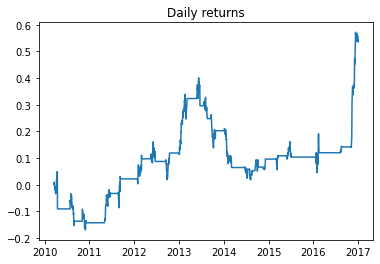

In [8]:
annual_returns, sharpe_ratio =\
    calculate_pnl_with_transaction_costs(price_data=price_data.to_frame(),
                                         positions=portfolio_positions,
                                         portfolio_ratios=portfolio_ratios,
                                         commissions_in_percent=0.25,
                                         bid_ask_spread=0.01)

print(f"Annual returns: {annual_returns}")
print(f"Sharpe ratio: {sharpe_ratio}")

### Conclusion

The annual returns and sharpe ratio aren't too impressive after accounting for transaction costs. This is expected since we are using a simple strategy with unoptimised hyperparameters.

In the next notebook we will tune hyperparameters via gridsearching and test out the strategy performance on out-of-sample data.